In [1]:
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


# Run

In [2]:
import pickle
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

import fasttext
import fasttext.util
from keras.models import Model
from keras.layers import Dropout,Input
# from tensorflow_addons.layers import CRF
from keras.layers import Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.callbacks import Callback
from keras.preprocessing.text import *
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.layers import GRU, SimpleRNN, LSTM, Bidirectional
from keras.layers import TimeDistributed
from keras.metrics import F1Score, Precision, Recall
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import AdamW
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.model_selection import GridSearchCV
# from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import AdamW, Adam, RMSprop, SGD

2024-03-10 12:41:59.845281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 12:41:59.845427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 12:41:59.996383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Embedding_name="fasttext"
Dataset="NER"     
PATH='/kaggle/input/nernlp3/'
OUTPATH='/kaggle/working/'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nernlp3/WordEmbeddings/glove.840B.300d.pkl
/kaggle/input/nernlp3/WordEmbeddings/Word2vec.bin
/kaggle/input/nernlp3/WordEmbeddings/cc.en.300.bin
/kaggle/input/nernlp3/Data/check.py
/kaggle/input/nernlp3/Data/NER_TRAIN_JUDGEMENT.json
/kaggle/input/nernlp3/Data/Laptop_Review_Val.json
/kaggle/input/nernlp3/Data/bio.ipynb
/kaggle/input/nernlp3/Data/Laptop_Review_Train.json
/kaggle/input/nernlp3/Data/bio1.py
/kaggle/input/nernlp3/Data/NER_TEST_JUDGEMENT.json
/kaggle/input/nernlp3/Data/Laptop_Review_Test.json
/kaggle/input/nernlp3/Data/processed/NER_test.json
/kaggle/input/nernlp3/Data/processed/ATE_test.json
/kaggle/input/nernlp3/Data/processed/NER_train.json
/kaggle/input/nernlp3/Data/processed/ATE_train.json
/kaggle/input/nernlp3/Data/processed/NER_val.json
/kaggle/input/nernlp3/Data/processed/ATE_val.json


In [4]:
! mkdir Saved_Models
! mkdir Saved_Models/ATE
! mkdir Saved_Models/NER
! mkdir Graphs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
def checking(a):
    print("Hello World",a)

def new_checking(a):
    print("Hello World",a)

def create_train_test_val(file):
    lst_out_text=[]
    lst_out_labels=[]
    for i in file.values():
        sentence = i['text']
        sentence = sentence.lower()
        labels = i['labels']
        lst_out_text.append(sentence)
        lst_out_labels.append(labels)
    return lst_out_text,lst_out_labels    

def TokenCreator(sentences,val,tokenizer=None):
    
    temp_wordlist = None
    tokenizer2=None
    if(tokenizer == None):
        if val==1:
            tokenizer2 = Tokenizer(oov_token="#UK",filters='')
        else:
            tokenizer2=Tokenizer()
        tokenizer2.fit_on_texts(sentences)
        
        temp_wordlist = tokenizer2.texts_to_sequences(sentences)
        return (temp_wordlist,tokenizer2)
    
    else:
        temp_wordlist = tokenizer.texts_to_sequences(sentences)
        return temp_wordlist
    
def find_vocab(dataset):
    lst=[]
    lst.append("#UK")
    for i in dataset:
        for j in i:
            lst.append(j)
    st = set(lst)
    return st

'''
--------------------------------------GRAPHS--------------------------------------
'''

def draw_loss_graph(model,model_name,f1_scores_train,f1_scores_val):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = [i+1 for i in range(len(train_loss))]
    train_y = train_loss
    val_y = val_loss
    
    fig, axes = plt.subplots(1,2,figsize = (16,5))
    # plt.subplots(axes = (2,1))
    axes[0].plot(x,train_y, color = 'blue')  
    
    axes[0].plot(x,val_y, color = 'red') 
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(x,f1_scores_train, color = 'blue')
    axes[1].plot(x,f1_scores_val, color = 'red')
    axes[1].set_title('F1 Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')

    axes[0].legend(['Train','Val'])
    axes[1].legend(['Train','Val'])
    
    plt.suptitle(model_name)

    
    plt.show()
    
'''
--------------------------------------MODELS--------------------------------------
'''

def save_model(model,model_name, embedding, dataset):
    with open(f'{OUTPATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name, embedding, dataset):
    with open(f'{OUTPATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model

'''
--------------------------------------CALLBACKS--------------------------------------
'''

class F1ScoreCallback(Callback):

    def __init__(self, val_data, data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.data=data
        self.val_f1_scores = [] 
        self.train_f1_scores = []

    

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.val_data
        x_data, y_data = self.data
        y_pred_val = self.model.predict(x_val)
        y_pred_train = self.model.predict(x_data)

        def scikitf1(pred,real):

            true_labels_flat = [label for sublist in real for label in sublist]
            predicted_labels_flat = [label for sublist in pred for label in sublist]
            # Compute F1 score
            f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
            return f1
        def get_pred(Y_padded_output):
                # print(Y_padded_output.shape)
                final_output=[]
                for i in range(Y_padded_output.shape[0]):
                    output=[]
                    for j in range(Y_padded_output.shape[1]):
                        max_value=-1
                        maxIndex=-1
                        for k in range(Y_padded_output.shape[2]):
                            if Y_padded_output[i][j][k]>max_value:
                                maxIndex=k
                                max_value=max(max_value,Y_padded_output[i][j][k])
                        output.append(maxIndex)
                    final_output.append(output)
                return final_output

        def get_real(Y_padded_test):
            # print(Y_padded_test.shape)
            final_Y=[]
            for i in range(Y_padded_test.shape[0]):
                output=[]
                for j in range(Y_padded_test.shape[1]):
                    max_value=-1
                    maxIndex=-1
                    for k in range(Y_padded_test.shape[2]):
                        if Y_padded_test[i][j][k]>max_value:
                            maxIndex=k
                            max_value=max(max_value,Y_padded_test[i][j][k])
                    output.append(maxIndex)
                final_Y.append(output)
            return final_Y
        
        # print("here")
        pred_train=get_pred(y_pred_train)
        # print(pred_train)
        real_train=get_real(y_data)
        # print(real_train)

        pred_val=get_pred(y_pred_val)
        real_val=get_real(y_val)

        f1_train = scikitf1(pred_train,real_train)
        f1_val = scikitf1(pred_val,real_val)

        self.val_f1_scores.append(f1_val)
        self.train_f1_scores.append(f1_train)
        print(f'Val F1 Score: {f1_val} - Train F1 Score: {f1_train}')



#---------Prediction Functions----------------------------------------------
def get_pred(Y_padded_output):
    final_output=[]
    for i in range(Y_padded_output.shape[0]):
        output=[]
        for j in range(Y_padded_output.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_output.shape[2]):
                if Y_padded_output[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_output[i][j][k])
            output.append(maxIndex)
        final_output.append(output)
    return final_output

def get_real(Y_padded_test):
    final_Y=[]
    for i in range(Y_padded_test.shape[0]):
        output=[]
        for j in range(Y_padded_test.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_test.shape[2]):
                if Y_padded_test[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_test[i][j][k])
            output.append(maxIndex)
        final_Y.append(output)
    return final_Y

def my_f1(y_true, y_pred):
    
    # predictions = get_pred(y_pred)
    # real = get_real(y_true)

    predictions = y_pred
    real = y_true

    size=len(predictions)

    unique_labels= set()

    for labels in real:
        unique_labels.update(labels)

    for labels in predictions:
        unique_labels.update(labels)

    labels_f1=[]

    for labels in unique_labels:
        tp=0
        fp=0
        fn=0

        for i in range(size):
            l=[]
                    
            tp+=sum((p==labels and r==labels) for p,r in zip(predictions[i],real[i]))
            fp+=sum((p==labels and r!=labels) for p,r in zip(predictions[i],real[i]))
            fn+=sum((p!=labels and r==labels) for p,r in zip(predictions[i],real[i]))

        
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall = tp/(tp+fn) if tp+fn>0 else 0

        f1=2*((precision*recall)/(precision+recall)) if precision+recall>0 else 0

        labels_f1.append(f1)
        print(f1,unique_labels)
    macro_f1 = sum(labels_f1)/len(unique_labels)
    return macro_f1

def scikitf1(pred,real):

    true_labels_flat = [label for sublist in real for label in sublist]
    predicted_labels_flat = [label for sublist in pred for label in sublist]
    # Compute F1 score
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
    return f1

In [6]:
seed_value = 18
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [7]:
if Embedding_name=="word2vec":
    emb = KeyedVectors.load_word2vec_format(f'{PATH}WordEmbeddings/Word2vec.bin',binary=True)

if Embedding_name=="glove":
    with open(f'{PATH}WordEmbeddings/glove.840B.300d.pkl', 'rb') as fp:
        emb = pickle.load(fp)
if Embedding_name=="fasttext":
    emb = fasttext.load_model(f'{PATH}WordEmbeddings/cc.en.300.bin')

# Data Extraction and Preprocessing

Reading ATE json files

In [8]:

train = None
test = None
val = None
with open(f"{PATH}Data/processed/{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"{PATH}Data/processed/{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"{PATH}Data/processed/{Dataset}_val.json") as f3:
    val = json.load(f3)



processing into lists

In [9]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

Tokenizing the ATE Dataset

In [10]:
X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

Vocabulary of ATE

In [11]:
st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 
vocab_size

30220

In [12]:
max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

max_len

70

Padding ATE

In [13]:
X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")       

One hot encoding the ATE labels

In [14]:
Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

Assigning **ATE Word2Vec** mapping

In [15]:
weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 
mapping

{'#UK': 1,
 'the': 2,
 'of': 3,
 'in': 4,
 'to': 5,
 'and': 6,
 'that': 7,
 'a': 8,
 'was': 9,
 'is': 10,
 'by': 11,
 'on': 12,
 'as': 13,
 'for': 14,
 'be': 15,
 'it': 16,
 'court': 17,
 'not': 18,
 'has': 19,
 'under': 20,
 'this': 21,
 'section': 22,
 'which': 23,
 'with': 24,
 'or': 25,
 'at': 26,
 'he': 27,
 'case': 28,
 'no.': 29,
 'from': 30,
 'been': 31,
 'his': 32,
 'an': 33,
 'had': 34,
 'are': 35,
 'were': 36,
 'v.': 37,
 'state': 38,
 'also': 39,
 'have': 40,
 'act': 41,
 'order': 42,
 'any': 43,
 'no': 44,
 'high': 45,
 'accused': 46,
 'learned': 47,
 'said': 48,
 'there': 49,
 'dated': 50,
 'supreme': 51,
 'made': 52,
 'would': 53,
 'before': 54,
 'singh': 55,
 'held': 56,
 'who': 57,
 'such': 58,
 'against': 59,
 'other': 60,
 'but': 61,
 'their': 62,
 'one': 63,
 'if': 64,
 'respondent': 65,
 'filed': 66,
 'appeal': 67,
 'appellant': 68,
 'evidence': 69,
 '&': 70,
 'all': 71,
 'only': 72,
 'decision': 73,
 'after': 74,
 'we': 75,
 'they': 76,
 'petitioner': 77,
 'govern

Fetching weights from pre trained Word2Vec model (ATE)

In [16]:
for word, index in mapping.items():
    if word in emb:
        weights[index:] = emb[word]

In [17]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2

In [18]:
Y_shape= Y_padded_train.shape[2]

# Models

## RNN

In [19]:
model_name="RNN"

### Training

In [20]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
rnn_model.add(SimpleRNN(32, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(Y_shape, activation='softmax')))

Compiling the rnn Word2Vec Model

In [21]:
rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [22]:
rnn_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))


In [23]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           9066000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 70, 32)            10656     
                                                                 
 time_distributed (TimeDist  (None, 70, 28)            924       
 ributed)                                                        
                                                                 
Total params: 9077580 (34.63 MB)
Trainable params: 11580 (45.23 KB)
Non-trainable params: 9066000 (34.58 MB)
_________________________________________________________________


Fitting the rnn model

In [24]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_val, Y_val), callbacks=[rnn_f1_callback])

Epoch 1/20
251/251 [==============================] - 2s 7ms/step
Val F1 Score: 0.0671265394810893 - Train F1 Score: 0.06751789193652753
63/63 [==============================] - 52s 805ms/step - loss: 1.8850 - acc: 0.7353 - precision: 0.9197 - recall: 0.2231 - val_loss: 0.8066 - val_acc: 0.8885 - val_precision: 0.9054 - val_recall: 0.8060
Epoch 2/20
251/251 [==============================] - 2s 7ms/step
Val F1 Score: 0.07471570430936471 - Train F1 Score: 0.07478813572811052
63/63 [==============================] - 49s 782ms/step - loss: 0.6444 - acc: 0.9018 - precision: 0.9127 - recall: 0.8398 - val_loss: 0.5723 - val_acc: 0.8976 - val_precision: 0.9090 - val_recall: 0.8459
Epoch 3/20
251/251 [==============================] - 2s 7ms/step
Val F1 Score: 0.08033705301741181 - Train F1 Score: 0.08048830036696493
63/63 [==============================] - 48s 779ms/step - loss: 0.5347 - acc: 0.9057 - precision: 0.9216 - recall: 0.8533 - val_loss: 0.4966 - val_acc: 0.9129 - val_precision: 0.9

Plotting the graph

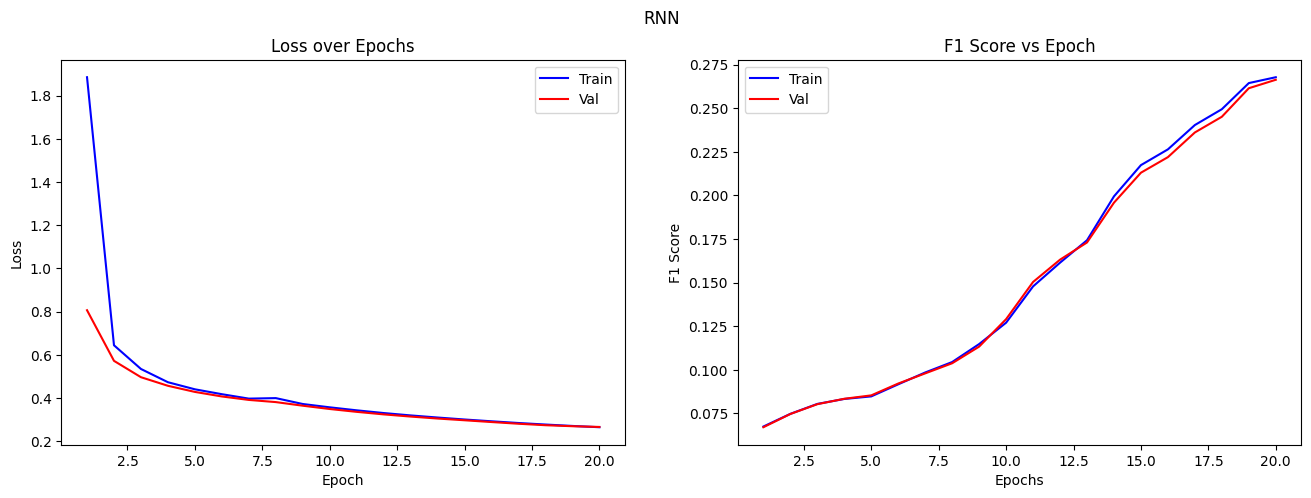

In [25]:
draw_loss_graph(rnn_training,model_name, rnn_f1_callback.train_f1_scores, rnn_f1_callback.val_f1_scores)
save_model(rnn_model,model_name,Embedding_name,Dataset)

### Testing

In [26]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [27]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 1s 10ms/step - loss: 0.2984 - acc: 0.9318 - precision: 0.9540 - recall: 0.9000
0.9318229556083679


Testing F1 Score

In [28]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 0s 7ms/step
Test F1 Score: 0.26557842703145823


## GRU

In [29]:
model_name="GRU"

### Training

In [30]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))

compiling 

In [31]:
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [32]:
gru_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [33]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 300)           9066000   
                                                                 
 gru (GRU)                   (None, 70, 64)            70272     
                                                                 
 time_distributed_1 (TimeDi  (None, 70, 28)            1820      
 stributed)                                                      
                                                                 
Total params: 9138092 (34.86 MB)
Trainable params: 72092 (281.61 KB)
Non-trainable params: 9066000 (34.58 MB)
_________________________________________________________________


Fitting GRU

In [34]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_val, Y_val), callbacks=[gru_f1_callback])

Epoch 1/20
251/251 [==============================] - 4s 15ms/step
Val F1 Score: 0.075765534250637 - Train F1 Score: 0.07659563523802458
63/63 [==============================] - 59s 905ms/step - loss: 1.8501 - acc: 0.7466 - precision_1: 0.8284 - recall_1: 0.3725 - val_loss: 0.7650 - val_acc: 0.9011 - val_precision_1: 0.9050 - val_recall_1: 0.8107
Epoch 2/20
251/251 [==============================] - 4s 16ms/step
Val F1 Score: 0.0880848461662691 - Train F1 Score: 0.08799233727425246
63/63 [==============================] - 57s 912ms/step - loss: 0.5693 - acc: 0.9102 - precision_1: 0.9253 - recall_1: 0.8421 - val_loss: 0.4774 - val_acc: 0.9182 - val_precision_1: 0.9325 - val_recall_1: 0.8632
Epoch 3/20
251/251 [==============================] - 4s 17ms/step
Val F1 Score: 0.09285160861668207 - Train F1 Score: 0.09356408558688732
63/63 [==============================] - 56s 894ms/step - loss: 0.4392 - acc: 0.9211 - precision_1: 0.9399 - recall_1: 0.8759 - val_loss: 0.4150 - val_acc: 0.9225

Plotting Graph

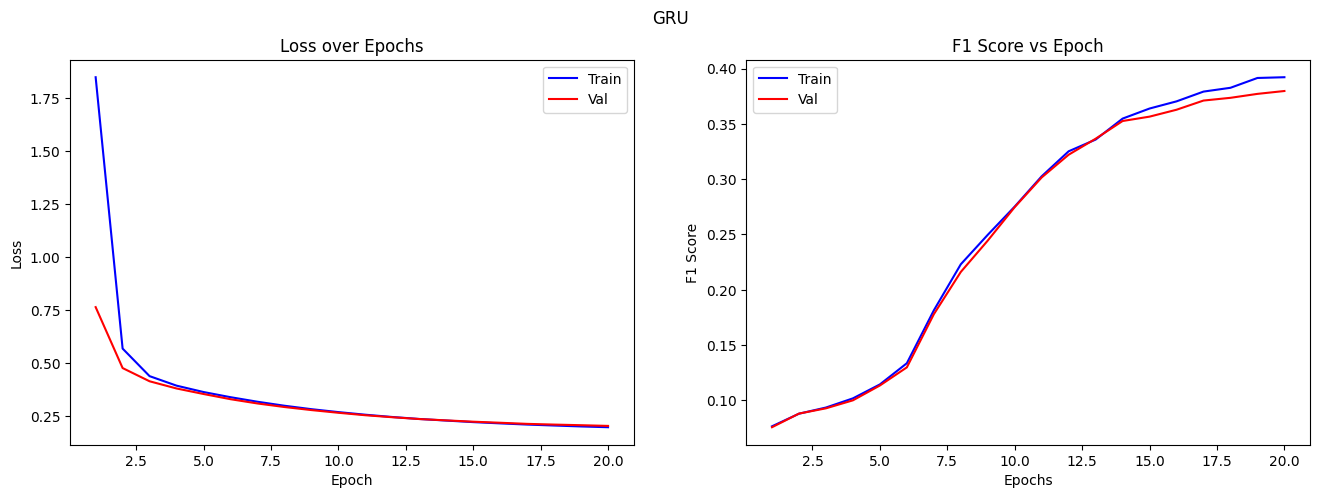

In [35]:
draw_loss_graph(gru_training,model_name, gru_f1_callback.train_f1_scores, gru_f1_callback.val_f1_scores)
save_model(gru_model,model_name,Embedding_name,Dataset)

### Testing

In [36]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing Accuracy

In [37]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 2s 16ms/step - loss: 0.2344 - acc: 0.9441 - precision_1: 0.9569 - recall_1: 0.9345
0.9440764784812927


Testing F1 Score

In [38]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 1s 15ms/step
Test F1 Score: 0.36473237501506134


## LSTM

In [39]:
model_name="LSTM"

### Training

In [40]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))# Lstm

Compiling LSTM

In [41]:
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [42]:
LSTM_f1_callback=F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [43]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 300)           9066000   
                                                                 
 lstm (LSTM)                 (None, 70, 128)           219648    
                                                                 
 time_distributed_2 (TimeDi  (None, 70, 28)            3612      
 stributed)                                                      
                                                                 
Total params: 9289260 (35.44 MB)
Trainable params: 223260 (872.11 KB)
Non-trainable params: 9066000 (34.58 MB)
_________________________________________________________________


Fitting LSTM

In [44]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_val, Y_val), callbacks=[LSTM_f1_callback])

Epoch 1/20
251/251 [==============================] - 9s 35ms/step
Val F1 Score: 0.07110011044587929 - Train F1 Score: 0.07146367797108188
63/63 [==============================] - 71s 1s/step - loss: 1.4367 - acc: 0.8059 - precision_2: 0.8716 - recall_2: 0.5539 - val_loss: 0.6611 - val_acc: 0.8962 - val_precision_2: 0.8986 - val_recall_2: 0.8058
Epoch 2/20
251/251 [==============================] - 9s 36ms/step
Val F1 Score: 0.08897411649712758 - Train F1 Score: 0.08845767111397833
63/63 [==============================] - 68s 1s/step - loss: 0.5658 - acc: 0.9123 - precision_2: 0.9220 - recall_2: 0.8362 - val_loss: 0.5083 - val_acc: 0.9192 - val_precision_2: 0.9307 - val_recall_2: 0.8507
Epoch 3/20
251/251 [==============================] - 9s 37ms/step
Val F1 Score: 0.09323712515162433 - Train F1 Score: 0.0930033062819982
63/63 [==============================] - 68s 1s/step - loss: 0.4755 - acc: 0.9209 - precision_2: 0.9386 - recall_2: 0.8601 - val_loss: 0.4482 - val_acc: 0.9242 - val_

Plotting Graph

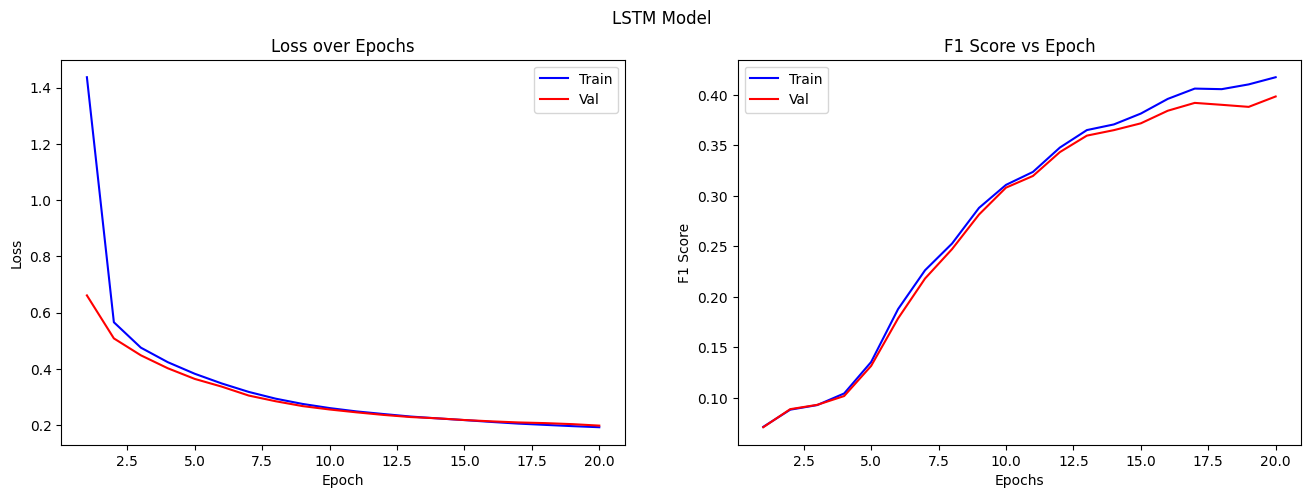

In [45]:
draw_loss_graph(lstm_training, "LSTM Model", LSTM_f1_callback.train_f1_scores, LSTM_f1_callback.val_f1_scores)
save_model(lstm_model, model_name, Embedding_name, Dataset)
loaded_model = load_model(model_name,Embedding_name,Dataset)

### Testing

In [46]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [47]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 2s 37ms/step - loss: 0.2242 - acc: 0.9466 - precision_2: 0.9589 - recall_2: 0.9369
0.9465904235839844


Testing F1 Score

In [48]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 2s 36ms/step
Test F1 Score: 0.38937607842921607


# BiLSTM

In [49]:
model_name="BiLSTM"